# 기업 주요 분석 과제 구현

---

## 총론

> 주제(기능)의 범위를 더 좁히는 것이 필요해 보임

- 기능이 매우 많은 것에 비해 각각 기능에 대한 구현 심도가 매우 높음.
- 이미 제공되고 있는 정보를 모아서 제공하거나, 크롤링/웹 검색 정보를 요약하는 수준의 프로젝트가 될 수 있을 듯 함.
- 따라서 기업에 대한 뉴스, 이슈, 리뷰 등에 집중하여 심도있는 프로젝트 제안

> 자사/경쟁사 뉴스/이슈 트렌드 분석 플랫폼

- 분석 목표 : 특정 기업 관련 뉴스/이슈 트렌드를 파악해 다음의 사항 분석
    1. 시간별 이슈 발생 빈도
    2. 긍정/부정 등 감성 추이
    3. 핵심 키워드 및 주제 변화
- 분석 프로세스
    1. 데이터 수집
        - API 활용 : API를 통해 기업 관련 최신 뉴스 헤드라인 수집
        - 크롤링 : 블로그 등 컨텐츠 수집
    2. 데이터 전처리
        - 텍스트 클렌징 (특수문자, 불용어 제거)
        - 감성 분석 (긍정/부정/중립 점수 계산)
            - 감성별 뉴스 분류
        - 날짜/시간 파싱
    3. 트렌드 분석
        - 일별 뉴스 빈도 추이 분석
        - 감성 점수 추적
        - 키워드 빈도 분석 (Word Cloud, lineplot)
            - 키워드별 뉴스 분류
    4. 토픽 모델링
        - LDA/Gensim 등 활용해 토픽 모델링
    5. 시각화
        - 시계열 추이 차트
        - 감성 분포 차트
        - 키워드 클라우드
        - 토픽 모델링 결과 네트워크 시각화
    6. 요약
        - 기업에 대한 각 키워드 별 뉴스를 요약하여 클릭/호버링 시 제공
        - 키워드에 대한 챗봇과 대화
- 출력 결과 (예상)
    1. 일별 뉴스 빈도 차트: 특정 일자에 집중된 이슈 발생 확인
	2. 감성 분포 차트: 긍정/부정 비율 파악
	3. 키워드 클라우드 / 키워드 추세선: ‘반도체’, ‘투자’, ‘규제’ 등 핵심 이슈 시각화
	4. 상위 키워드 리스트: 빈도 기반 주제 분석
    5. 네트워크 분석
    6. 키워드별 뉴스/이슈 요약 정보
    7. 키워드별 챗봇
- 기능의 확장
    - 다중 기업 비교: 기업별 분석 결과 제공 -> 경쟁사와 이슈 비교 가능

---

## 0. Import

In [4]:
import os
from dotenv import load_dotenv
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import plotly.graph_objects as go

from selenium import webdriver
from selenium.webdriver.common.by import By

from typing import Annotated, List
from typing_extensions import TypedDict

from pydantic import BaseModel

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

In [2]:
load_dotenv()

True

## 1. 기업 개요/현황

### 1-1. 기본 정보/규모

> 설립 연도, 위치, 조직 규모, 대표 이사, 주 사업 분야 등

- 잡코리아

In [111]:
class BaseInfoLoader:
    def __init__(self, url):
        self.url = url
        self.contents = []
    
    def load(self, in_pandas=False):
        # search url
        driver = webdriver.Chrome()
        driver.get(self.url)

        # find element with xpath
        elements = driver.find_elements(By.XPATH, '//*[@id="company-body"]/div[1]/div[1]/div/table')
        for element in elements:
            self.contents.append(element.text)
        
        # create base info dict
        keys = []
        values = []        
        for idx, text in enumerate(self.contents[0].split('\n')[1:]):
            keys.append(text) if idx%2==0 else values.append(text)
        self.info_dict = {
            key : value
            for key, value in zip(keys, values)
        }

        if in_pandas:
            info_df = pd.DataFrame([self.info_dict])
            return info_df
        else:
            return self.info_dict


In [112]:
url = "https://www.jobkorea.co.kr/Company/1696583"

loader = BaseInfoLoader(url)

In [ ]:
info_df = loader.load(in_pandas=True)

info_df

In [ ]:
loader.info_dict

{'산업': '이동전화기 제조업',
 '사원수': '129,095명 (2024.12.31)',
 '기업구분': '대기업',
 '설립일': '1969.12.01 (57년차)',
 '자본금': '8,975억 1천만원 (2024.12.31)',
 '매출액': '209조 5백억원 (2024.12.31)',
 '대표자': '전영현',
 '대졸초임': '5,163만원 상세보기',
 '주요사업': '휴대폰,컴퓨터,네트워크시스템,핵심칩,반도체부품,디스플레이패널,가전제품,의료기기,프린터 제조',
 '4대보험': '국민연금, 건강보험, 고용보험, 산재보험',
 '홈페이지': 'http://www.samsung.com/sec',
 '주소': '경기 수원시 영통구 삼성로 129 (매탄동, 삼성전자)',
 '계열사': '삼성그룹 스테코(주) 삼성전자판매(주) 삼성벤처투자(주) 삼성전자로지텍(주) (주)시큐아이 (주)씨브이네트 (주)멀티캠퍼스 삼성생명서비스손해사정(주) (주)미라콤아이앤씨 세메스(주) 에스디플렉스(주) 삼성중공업(주) 삼성SDI(주) 삼성전기(주) 삼성메디슨(주) (주)하만인터내셔널코리아 더보기'}

### 1-2. 비즈니스 모델


비즈니스 모델의 핵심 구성 요소:

- 고객 관계: 지속적인 관계를 조성하고 시간이 지남에 따라 고객 충성도를 구축하는 방법에 중점
- 가치 제안: 제품 또는 서비스를 독특하고 매력적이며 고객에게 가치 있는 것으로 만드는 요소를 정의
- 목표 고객: 이상적인 고객과 그들의 가장 시급한 니즈를 파악
- 수익 흐름: 비즈니스가 어떻게 수입을 창출하는지 설명
- 비용 구조: 비즈니스를 이끄는 주요 운영 비용을 강조
- 핵심 리소스: 성공에 중요한 물리적, 인적, 재정적 또는 지적 재산과 같은 필수 자산에 대해 설명
- 배포 채널: 제품 또는 서비스를 고객과 연결하고 고객에게 제공하는 방법을 설명

> 이후 분석 과제에서 '고객층', '차별화 요소' 에 대한 분석이 이루어지므로,

> '수익 흐름', '비용 구조' 를 중심으로 시각화 하는 것이 좋을 듯
>> 이를 위해서는 '재무제표'활용 필요

In [ ]:
labels = [
    "DX부문 매출", "DS부문 매출", "SDC", "Harman", "기타", # 1단계
    "총 매출",                                         # 2단계
    "매출총이익", "매출원가",                             # 3단계 
    "영업이익", "판매비와관리비",                              # 4단계
    "순이익", "법인세", "판매비와관리비", "기타비용"           # 5단계
]

# 단계별로 source와 target을 연결
source = [0, 1, 2, 3, 4, 5, 5, 6, 6, 8, 8, 9, 9]
target = [5, 5, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13]
values = [1748877, 1110660, 291578, 142749, 285155, 
          1143086, 1865622, 
          327259, 815826, 
          815826, 327259]

fig = go.Figure(go.Sankey(
    node=dict(
        pad=15, thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
))

fig.update_layout(title_text="삼성전자 수익구조", font_size=10)

### 1-3. 기업 평가/인식 분석

> 뉴스, 보도자료, 리뷰 등 인터넷 자료 수집 및 분석
>> 워드클라우드, 긍/부정, 네트워크분석 등 ...

- 기업 평가 및 인식
    1. 기업 브랜드 인식
    2. 제품 인식

`TavliySearchResult`

Parameter
- max_depth : 검색 결과 수
- search_depth : 검색의 깊이 ('basic' or 'advanced')
- include_domain : 검색 결과에 포함시킬 도메인 (default='None'(=all domain))
- exclude_domain : 검색 결과에 제외시킬 도메일 (default='None'(=모두 포함))
- include_answer : 최초 query에 대한 짧은 답변을 검색 결과에 포함시킬지 여부 (default=False)
- include_raw_content : 검색한 사이트의 원본 HTML을 포함시킬지 여부 (정제/파싱된 HTML, default=False)
- include_image : query와 연관되어 검색된 이미지의 리스트를 검색 결과에 포함시킬지 여부 (default=False)

```
> tavily search result schema

{
    'title' : ,
    'url' : ,
    'content' : ,
    'score' : ,
}
```

In [75]:
tavily_search_tool = TavilySearchResults(
    max_results=5
)

llm = ChatOpenAI(
    temperature=0.5,
    model="gpt-4o"
)

In [76]:
class TavilyQueryListModel(BaseModel):
    query_list: Annotated[List[str], "list of query that should invoke with tavliy search tool"]

In [77]:
llm_with_tool = llm.bind_tools([tavily_search_tool])

query_response_llm = llm_with_tool.with_structured_output(TavilyQueryListModel)

today = datetime.datetime.today()
query_make_system_prompt = f"""당신은 시장 분석가를 보조하는 AI 어시스턴트입니다. 오늘은 {today}입니다.
당신의 임무는 고객이 원하는 기업에 대해 시장 분석가가 기업 브랜드/기업의 제품에 대한 최근 대중의 리뷰/반응을 검색할 수 있는 '검색어(질문)'을 만드는 것입니다.
검색 범위를 최대한 넓히고 누락을 최소화하는 고품질 검색어를 생성하세요.

다음의 사고 루프를 반복하며 임무를 수행하세요.
<루프>
1. 사고: 다음 단계에서 어떤 정보나 접근이 필요한지 숙고한다.
2. 행동: 구체적인 검색어 또는 질문을 초안으로 작성한다.
3. 관측: (시뮬레이션) 해당 검색어로 어떤 최신 컨텐츠가 나올지 점검 후, 검색 도구를 활용해 실제 검색을 수행하고 결과를 검토해 수정한다.
</루프>

최소 5개 이상의 주제 버킷에 걸쳐 총 30개 이상의 고품질 검색어/질문을 생성하면 절차를 종료하세요.
"""

query_make_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        query_make_system_prompt
    ),
    (
        "human",
        "{company}에 대한 대중의 리뷰/반응을 확인할 수 있도록 '검색어(질문)'을 생성해주세요."
    )
])

In [78]:
query_maker = create_react_agent(
    model=llm,
    tools=[tavily_search_tool],
    response_format=TavilyQueryListModel,
    prompt=query_make_system_prompt
)

In [79]:
company = "삼성전자"

In [80]:
response = query_maker.invoke({
    "messages" : [
        HumanMessage(
            content = f"{company}에 대한 대중의 리뷰/반응을 확인할 수 있도록 '검색어(질문)'을 생성해주세요."
        )
    ]
})

In [81]:
response['structured_response'].query_list

['2025년 삼성전자 스마트폰 사용자 리뷰',
 '삼성전자 가전제품 최신 사용자 평가',
 '삼성 TV 2025년 고객 만족도',
 '삼성 노트북 최근 사용자 피드백',
 '삼성전자 신제품 리뷰 2025',
 '삼성전자 브랜드 이미지 2025',
 '삼성전자 기업 평판 최근 변화',
 '소셜 미디어에서의 삼성전자 브랜드 인식',
 '삼성전자의 지속 가능성 노력에 대한 대중의 반응',
 '삼성전자 고객 서비스에 대한 최근 평가',
 '삼성전자의 최신 기술 혁신에 대한 대중의 반응',
 '삼성전자의 인공지능 기술 발전 평가',
 '삼성전자 5G 기술에 대한 사용자 리뷰',
 '삼성전자 반도체 기술 혁신에 대한 시장 반응',
 '삼성전자의 친환경 기술에 대한 대중의 의견',
 '삼성전자와 애플의 제품 비교 2025',
 '삼성전자와 LG전자 가전제품 비교 리뷰',
 '삼성전자와 화웨이의 스마트폰 경쟁에 대한 대중의 의견',
 '삼성 TV와 소니 TV 비교 2025',
 '삼성전자와 샤오미의 시장 점유율 비교',
 '삼성전자 제품 구매 트렌드 2025',
 '2025년 삼성전자 인기 제품 순위',
 '삼성전자 제품에 대한 소비자 선호도 변화',
 '삼성전자 제품의 가성비에 대한 대중의 평가',
 '삼성전자 제품 구매를 결정하는 주요 요인',
 '미국 시장에서의 삼성전자 제품 반응',
 '유럽 소비자들의 삼성전자 제품 평가',
 '아시아 시장에서의 삼성전자 브랜드 인식',
 '중동 지역 삼성전자 제품 리뷰',
 '남미 시장에서의 삼성전자 제품 인기']

In [82]:
query_list = response['structured_response'].query_list

In [83]:
query_list[0]

'2025년 삼성전자 스마트폰 사용자 리뷰'

In [84]:
search_results = []

for query in tqdm(query_list):
    search_result = tavily_search_tool.invoke({"query" : query})

    search_results.extend(search_result)

100%|██████████| 30/30 [02:25<00:00,  4.84s/it]


In [85]:
search_results

[{'title': '2025년 최고의 삼성핸드폰 Top10! 구매 전 리뷰 보기! - YouTube',
  'url': 'https://www.youtube.com/watch?v=esEE4tFquF4',
  'content': '요즘 인기있는 삼성핸드폰 구매 가격 평점 리뷰 정리해 봤어요! ❤️❤️❤️ [00:06] 10위. #삼성전자 ... 갤럭시 스마트폰이라면 꼭 켜서 사용하세요 | 갤럭시',
  'score': 0.7152057},
 {'title': '부모님도 만족할 기능! 2025 3월 자급제효도폰 추천 ㅣ 삼성 A시리즈 ...',
  'url': 'https://www.youtube.com/watch?v=Ks6TZmu5Ys4',
  'content': '13:09. Go to channel · 2025 현시점 가장 가성비 좋은 스마트폰 TOP5 ... 갤럭시 A16 사용 후기 : 그러니까 이건 살짝 커진 A15랄까요,. postiVIEW',
  'score': 0.6811549},
 {'title': '2025년 제품 선호도가 좋은! 갤럭시35! 베스트 TOP10! 가격 평점 리뷰 ...',
  'url': 'https://www.youtube.com/watch?v=5hwbFgvitys',
  'content': '가격 평점 리뷰 후기 총정리!! 1 view · 2 hours ago #갤럭시 #삼성전자 #삼성 ... ... 2025 현시점 가장 가성비 좋은 스마트폰 TOP5 비교 추천 구매가이드',
  'score': 0.67527276},
 {'title': '2025년 여러분이 고민하는! 삼성갤럭시북5프로360! 베스트 TOP10 ...',
  'url': 'https://www.youtube.com/watch?v=_U9_a2_mCzg',
  'content': '가격 평점 리뷰 후기 총정리!! 42 views · 3 months ago #삼성노트북 #삼성전자 #삼성갤럭시북5프로360추천 ... 2025 현시점 가장 가성비 좋은 스마트폰',
 

In [87]:
len(search_results)

137

In [89]:
search_results_df = pd.DataFrame(search_results)

In [91]:
search_results_df.to_csv("./data/search_results.csv", index=False)

In [95]:
search_results_df["url"]

0            https://www.youtube.com/watch?v=esEE4tFquF4
1            https://www.youtube.com/watch?v=Ks6TZmu5Ys4
2            https://www.youtube.com/watch?v=5hwbFgvitys
3            https://www.youtube.com/watch?v=_U9_a2_mCzg
4      https://m.blog.naver.com/PostView.naver?blogId...
                             ...                        
132    https://www.sisajournal-e.com/news/articleView...
133    https://news.samsung.com/kr/%EC%82%BC%EC%84%B1...
134    http://www.wikileaks-kr.org/news/articleView.h...
135            https://news.nate.com/view/20250602n23780
136       https://www.hankyung.com/article/202503052975g
Name: url, Length: 137, dtype: object

## 2. 시장 분석

### 2-1. 시장 현황

1. 이슈 정리
2. 주요 규제 사항/파급 효과 정리
3. 트렌드 분석

In [1]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import time

plt.rc('font', family='AppleGothic') 			## 이 두 줄을 
plt.rcParams['axes.unicode_minus'] = False  ## 추가해줍니다. 

/opt/anaconda3/envs/company_breif_pjt/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
trends = TrendReq(hl='ko')

In [3]:
industry_keywords = ['스마트폰', '전자기기', '인공지능']

timeframe = 'today 12-m'

In [6]:
trend_data = None

for keyword in industry_keywords:
    trends.build_payload(keyword, timeframe=timeframe, geo='KR')
    time.sleep(30)
    if trend_data is None:
        trend_data = trends.interest_over_time()
    else:
        trend_data = pd.concat([trend_data, trends.interest_over_time()])

    

TooManyRequestsError: The request failed: Google returned a response with code 429

In [7]:
trend_data.head()

,스마트폰,전자기기,인공지능,isPartial
date,,,,
2024-06-02,61,9,80,False
2024-06-09,64,9,91,False
2024-06-16,60,10,79,False
2024-06-23,59,8,57,False
2024-06-30,61,8,55,False


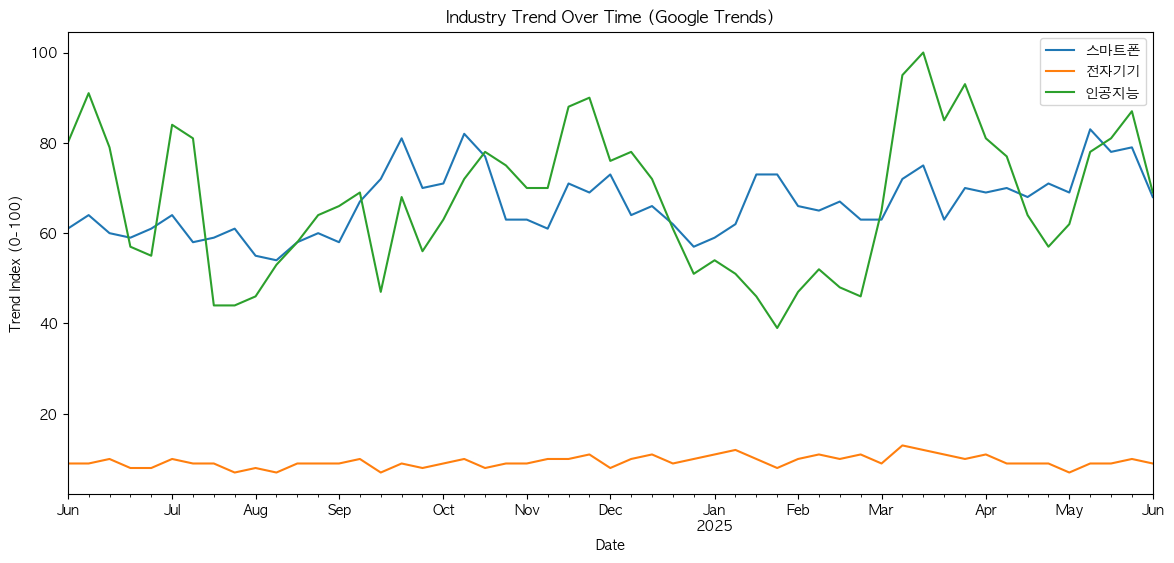

'스마트폰' 최근 1년 평균 트렌드: 66.65, 전체 평균: 66.55, 변화율: 0.16%
→ '스마트폰'는 최근 1년간 트렌드가 안정적입니다.

'전자기기' 최근 1년 평균 트렌드: 9.42, 전체 평균: 9.42, 변화율: 0.08%
→ '전자기기'는 최근 1년간 트렌드가 안정적입니다.

'인공지능' 최근 1년 평균 트렌드: 66.98, 전체 평균: 67.23, 변화율: -0.37%
→ '인공지능'는 최근 1년간 트렌드가 안정적입니다.



In [12]:
trend_data[industry_keywords].plot(figsize=(14,6))
plt.title('Industry Trend Over Time (Google Trends)')
plt.ylabel('Trend Index (0-100)')
plt.xlabel('Date')
plt.legend(industry_keywords)
plt.show()

# 7. 최근 1년 평균과 전체 평균 비교로 트렌드 변화 진단
for kw in industry_keywords:
    mean_5y = trend_data[kw].mean()
    mean_1y = trend_data[kw][-52:].mean()  # 최근 52주 평균
    change = round(((mean_1y / mean_5y) - 1) * 100, 2)
    print(f"'{kw}' 최근 1년 평균 트렌드: {mean_1y:.2f}, 전체 평균: {mean_5y:.2f}, 변화율: {change}%")

    # 간단한 해석
    if abs(change) <= 5:
        print(f"→ '{kw}'는 최근 1년간 트렌드가 안정적입니다.")
    elif change > 5:
        print(f"→ '{kw}'는 최근 1년간 트렌드가 상승 중입니다.")
    else:
        print(f"→ '{kw}'는 최근 1년간 트렌드가 하락 중입니다.")
    print()

### 2-2. 소비자 행동(구매) 패턴

- 거래/구매 데이터, 로그 데이터는 공개된 정보 수집이 어려움..
- 현실적으로 고객에 대해 수집할 수 있는 데이터는 리뷰/블로그/영상 등 반응 데이터
- 이는 기업 인식/반응 분석과 겹치게 됨...

### 2-3. 시장 발전 방향성

- 2가지 방향성 존재할 듯.
    1. 전문가들이 예견한 발전 방향성(뉴스, 포럼 등) 수집 및 요약
    2. 필요한 데이터를 직접 수집하여 모델이 예측
- '2번'의 경우 자체 데이터셋 구성 필요할 듯.
    - 단순히 수집한 데이터를 올바르게 요약하는 것이 아닌 추론의 영역이므로, 발전 방향성을 추론하는 과정을 담은 벤치마크 데이터셋 구성 필요
    - 주제를 이것으로 좁히면 가능할 듯 (여러 기능이 종합된 상황이라면 현실적으로 불가능 예상)

## 3. 재무 분석

### 3-1. 주요 재무 성과

- 잡코리아에서 기본적인 재무분석 정보 제공 중
    - 최근 4개년 및 업계 평균 대비 매출/영업이익/당기순이익
    - 산업 내 위치(활동성, 수익성, 안정성, 성장성 기준)
    - 기업 등급, 총자산 증가율
- 사용한다면 해당 정보를 가져오는 것이 현실적일 듯

### 3-2. 시장 점유율

- 산출 시나리오
    1. 잡코리아에서 동종 업계 기업 리스트 크롤링
        - 잡코리아에서 동종 업계 기업 순위까지 제공 중 (다만, 구체적인 수치는 제공하지 않음)
        - 잡코리아 동종 업계 순위는 표준산업 분류 기준 [000]의 공시된 재무정보(매출액)를 기준으로 평가된 순위 제공 중
    2. 각 기업 별 동분기 매출 수집
        - 사업보고서 등 수집 필요
        - 사업보고서 파싱 필요
    3. (해당 기업 매출) / (총 매출) * 100 으로 점유율 산출

## 4. 제품/서비스 분석

### 4-1. 제품 목록에 대한 특징/품질

- 제품 특징/품질
    - 제품에 대한 자세한 스펙은 공식 판매처에서 확인 가능
    - 추가로 블로그/유튜브 등 제품 리뷰 컨텐츠를 확인하여 고객의 시각에서 제품 특징 확인 가능

### 4-2. 차별화 요소 분석

- 상동

### 4-3. 고객 리뷰/반응/충성도

- 판매처 (쿠팡, 네이버 스마트쇼핑 등 이커머스 사이트)의 고객 리뷰 데이터를 크롤링하여 분석
    - 리뷰에는 광고성 리뷰도 존재하기에 내용을 보고 분류 필요

### 4-4. R&D 활동 현황

## 5. 마케팅/브랜딩 전략 분석